# Modeling with different timesteps
*Developed by D.A. Brakenhoff, Artesia*

This notebooks contains examples how to model with pastas with non-daily timesteps.


## The difference between the model timestep and the observation frequency

The model timestep is the time interval on which the heads are simulated by the
Pastas model. The observation frequency is the time interval between two head
observations. By default Pastas uses a daily modeling timestep, whereas the
timestep between observations can vary:

- If the observation frequency is higher (e.g. hourly) Pastas will take a daily sample of head observations to fit the model.
- If the observation frequency is lower (e.g. weekly), Pastas will calibrate the model on those weekly observations. 
- The observation frequency can even be irregular, meaning that the timestep between two observations does not have to be constant. 

In this notebook we're showing how to use Pastas to model with different
timesteps. The observation frequency is related to this choice, but does not
have to be the same as the modeling timestep.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import hydropandas as hpd

ps.show_versions()
ps.logger.setLevel("ERROR")

Python version: 3.9.7
NumPy version: 1.21.2
Pandas version: 1.5.3
SciPy version: 1.10.0
Matplotlib version: 3.7.0
Numba version: 0.55.1
LMfit version: 1.0.3
Latexify version: 0.2.0
Pastas version: 1.0.1


Before we get to the modeling, we define a helper function to generate
synthetic heads using an input stress and a response function with known
parameters.

In [2]:
def generate_synthetic_heads(
    input,
    rfunc,
    params,
    cutoff=0.9999,
    dt=1.0,
    constant=0.0,
    noise="none",
    sigma_n=0.1,
    alpha=2.0,
):
    # Generate the head
    step = rfunc.block(params, cutoff=cutoff, dt=dt)

    h = constant * np.ones(len(input) + step.size)

    for i in range(len(input)):
        h[i : i + step.size] += input[i] * step

    head = pd.Series(
        index=input.index,
        data=h[: len(input)],
    )

    # add random (uncorrelated) noise
    if noise == "random":
        residuals = random_seed.normal(0, 1, len(head)) * sigma_n
        head = head + residuals

    # add correlated noise AR(1)
    elif noise == "correlated":
        delt = (head.index[1:] - head.index[:-1]).values / pd.Timedelta("1d")
        noise = sigma_n * np.random.randn(len(head))
        residuals = np.zeros_like(noise)
        residuals[0] = noise[0]
        for i in range(1, head.index.size):
            residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
        head = head + residuals

    return head

## A 14-day model (and comparing it to a daily model)
---

In this example we generate heads from measured precipitation and evaporation
using a known response function. Next we take a sample from the synthetically
generated heads with one observation every 14 days. Then we build 3 pastas
models:

1. Model with daily timestep
2. Model with 14-day timestep, where we let pastas resample the stresses.
3. Model with 14-day timestep, where we use manually resampled stresses.

The three Pastas models are expected to give very similar results.

First we read in some real precipitation and evaporation data.

In [3]:
prec = pd.read_csv(
    "../../doc/examples/data/rain_260.csv", index_col=[0], parse_dates=True
).squeeze()
evap = pd.read_csv(
    "../../doc/examples/data/evap_260.csv", index_col=[0], parse_dates=True
).squeeze()

Define a response function and its parameters.

In [4]:
rfunc = ps.Exponential()
Atrue = 0.8
atrue = 50
ftrue = -1.3  # evaporation factor
constant = 20  # constant level
params = [Atrue, atrue]

Calculate effective precipitation using a linear recharge model with
evaporation factor `f`. Use this stress to generate a synthetic head time
series.

In [5]:
stress = prec + ftrue * evap

head = generate_synthetic_heads(stress, rfunc, params, constant=constant)
head = head.loc["1990":"2015"]

Take a sample from the heads with one observation every 2 weeks.

In [6]:
sample_step = 14
freq = f"{sample_step}D"

sample = head.iloc[::sample_step].asfreq(freq)

Plot synthetic head time series.

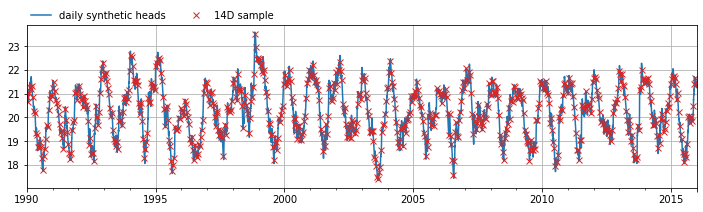

In [7]:
ax = head.plot(figsize=(12, 3), label="daily synthetic heads")
sample.plot(ax=ax, marker="x", color="C3", ls="none", label=f"{freq} sample")
ax.legend(loc=(0, 1), frameon=False, ncol=2)
ax.grid(True)

Manually resample stresses to a two-weekly frequency. We take the mean to
ensure the resulting parameters estimated by the pastas model have the same
units. (If we took the sum, we would have to divide the gain `recharge_A` by
the number of days in our period, in this case 14.) Using this method we can
ensure the stresses align with the heads sample. The mean precipitation and
evaporation are calculated over the two week periods prior to each head
observation.

In [8]:
p_resampled = prec.resample(
    freq, closed="right", label="right", origin=sample.index[0]
).mean()
e_resampled = evap.resample(
    freq, closed="right", label="right", origin=sample.index[0]
).mean()

Now we create three pastas models and fit them on the heads sample.

1. Model 1 uses a daily timestep.
2. Model 2 uses a 14-day timestep, and lets Pastas do the resampling.
3. Model 3 uses a 14-day timestep, and uses our manually resampled stresses.

How do we get Pastas to use a 14-day timestep? This is done by supplying the
`freq` keyword argument to the `Model`, e.g.:

```python
    ps.Model(head, freq="14D")
```

In [9]:
# model 1: daily timestep
ml_01D = ps.Model(sample, name="01D")
rm = ps.RechargeModel(prec, evap, rfunc=rfunc, name="recharge")
ml_01D.add_stressmodel(rm)
ml_01D.solve(noise=False, report=False)

# model 2: 14D timestep, let pastas resample stresses with daily freq to 14D
ml_14D_ps = ps.Model(sample, name=f"{freq}_ps", freq=freq)
rm = ps.RechargeModel(prec, evap, rfunc=rfunc, name="recharge")
ml_14D_ps.add_stressmodel(rm)
ml_14D_ps.solve(noise=False, report=False)

# model 3: 14D timestep, use manually resampled stresses from daily to 14D
ml_14D = ps.Model(sample, name=freq, freq=freq)
ml_14D.settings
rm = ps.RechargeModel(p_resampled, e_resampled, rfunc=rfunc, name="recharge")
ml_14D.add_stressmodel(rm)
ml_14D.solve(noise=False, report=False)

Visually compare the results of the three models for the period between March and June in 1990.

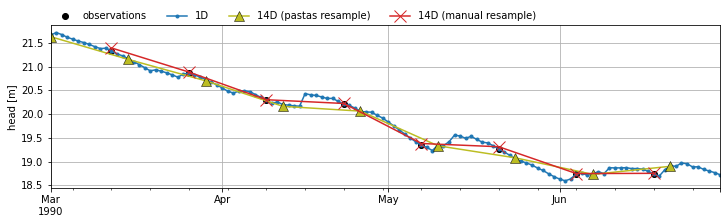

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

sample.loc["1990-03":"1990-06"].plot(
    ax=ax, linestyle="none", marker="o", color="k", label="observations"
)

ml_01D.simulate().loc["1990-03":"1990-06"].plot(ax=ax, marker=".", label="1D")
ml_14D_ps.simulate().loc["1990-03":"1990-06"].plot(
    ax=ax,
    marker="^",
    ms=10,
    mec="k",
    mew=0.5,
    c="C8",
    label=f"{freq} (pastas resample)",
)
ml_14D.simulate().loc["1990-03":"1990-06"].plot(
    ax=ax, marker="x", ms=12, c="C3", label=f"{freq} (manual resample)"
)

ax.legend(loc=(0, 1), frameon=False, ncol=4)
ax.set_ylabel("head [m]")
ax.grid(True)

As expected the fit for each of the models is equal or very close to 1.0.

In [11]:
comparison = ps.CompareModels([ml_01D, ml_14D_ps, ml_14D])
fit = comparison.get_metrics(metric_selection=["rsq"]).T
fit.index.name = "Model"
fit.round(3)

,rsq
Model,
01D,1.000
14D_ps,0.985
14D,0.999


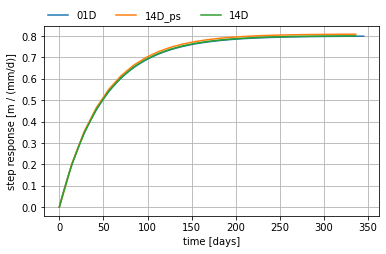

In [12]:
ax = comparison.plot_response()
ax.figure.set_figheight(3.5)
ax.figure.set_figwidth(6)
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles, [iml.name for iml in comparison.models], loc=(0, 1), frameon=False, ncol=3
)
ax.grid(True)
ax.set_ylabel("step response [m / (mm/d)]")
ax.set_xlabel("time [days]");

And let's take a look at the estimated parameters and the true values.

In [13]:
dfparams = comparison.get_parameters()
dfparams["True values"] = params + [ftrue, constant]
dfparams.round(3)

,01D,14D_ps,14D,True values
recharge_A,0.800,0.809,0.801,0.8
recharge_a,49.964,49.178,49.621,50.0
recharge_f,-1.301,-1.293,-1.298,-1.3
constant_d,20.002,19.989,19.998,20.0


Note that these differences are expected. The daily model is able to almost
perfectly simulate the heads because the heads were also generated on a daily
basis. The Pastas resampled model performs worst, since it is calibrating the
model on interpolated observations, which is obviously a slightly different
time series than the original heads sample. This happens because Pastas
resamples the stresses in such a way that they do not align with the timing of
the head observations. When we manually resample, we can ensure the indices
between the stresses and the observations match, and we see that the fit and
the parameters are nearly identical to the model with a daily timestep. A small
difference remains because the 14-day model cannot account for the timing of
the rainfall within a 14-day period. The generated heads are different if all
precipitation falls at the beginning of the two-week period as compared to all
rainfall falling at the end of the two-week period.

## Hourly models
---

A higher temporal resolution is sometimes necessary when head changes occur
quickly, for example, heads that are affected by tidal fluctuations or the
drawdown during pumping tests.


### Tidal example

In this first example we'll generate a synthetic heads timeseries based on
tidal fluctuations. These tidal fluctuations follow a simple sine wave with a
period of 12 hours and 25 minutes.

In [14]:
Atide = 1.5  # tidal amplitude

# sine with period 12 hrs 25 minutes
tides = Atide * np.sin(2 * np.pi * np.arange(head.index.size * 24) / (0.517375))

# convert to Series
tides = pd.Series(
    index=pd.date_range(
        head.index[0], head.index[-1] + pd.Timedelta(hours=23), freq="H"
    ),
    data=tides,
)

Next we define a response function and its parameters to convert the tidal fluctuations into a synthetic head time series.

In [15]:
rf_tide = ps.Exponential()
A_tide = 1.0
a_tide = 0.15

Apply the response function and its parameters to our tidal stress to generate the synthetic heads.

In [16]:
ht = generate_synthetic_heads(tides, rf_tide, (A_tide, a_tide), dt=1 / 24.0)
htsel = ht.loc["2000-01-01":"2005-12-31"]

Plot the tidal stress and the resulting head.

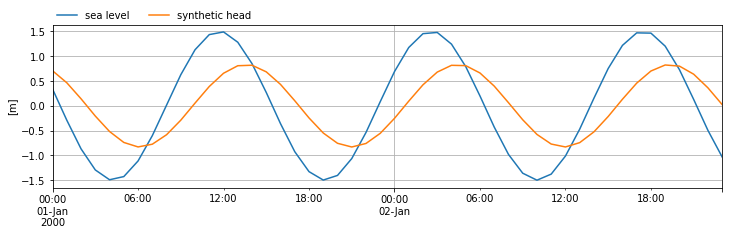

In [17]:
ax = tides.loc["2000-01-01":"2000-01-02"].plot(figsize=(12, 3), label="sea level")
htsel.loc["2000-01-01":"2000-01-02"].plot(ax=ax, label="synthetic head")
ax.grid(True)
ax.legend(loc=(0, 1), frameon=False, ncol=2)
ax.set_ylabel("[m]");

Next we build two Pastas models, one with daily timestep and the other with an hourly timestep. 

In [18]:
# model with daily timestep
ml_D = ps.Model(htsel, name="daily", freq="D")
sm = ps.StressModel(
    tides.loc["1995":"2005"],
    rfunc=ps.Exponential(),
    name="sealvl",
    settings="waterlevel",
)
ml_D.add_stressmodel(sm)
ml_D.solve(noise=False, report=False)

# model with hourly timestep
ml_H = ps.Model(htsel, name="hourly", freq="H")
sm = ps.StressModel(
    tides.loc["1995":"2005"],
    rfunc=ps.Exponential(),
    name="sealvl",
    settings="waterlevel",
)
ml_H.add_stressmodel(sm)
ml_H.solve(noise=False, report=False)

If we look at the R² value of both models we can see that the daily model is performing poorly. 

In [19]:
comp = ps.CompareModels([ml_D, ml_H])
comp.get_metrics(metric_selection=["rsq"]).round(3)

,daily,hourly
rsq,0.698,1.0


A glance at the estimated parameters, as compared to the true values of the
parameters, shows that, as the fit statiscs suggest, the daily model is not
able to estimate the parameters well.

In [20]:
dfparams = comp.get_parameters()
dfparams["True values"] = params + [0.0]
dfparams.round(3)

,daily,hourly,True values
sealvl_A,82.572,0.998,0.8
sealvl_a,17.951,0.150,50.0
constant_d,0.000,0.000,0.0


Plotting comparisons between the observations and the simulations for both
models shows that the daily model is not able to match the observations,
whereas the hourly model is perfectly able to simulate the tidal fluctuations.
This is what we would expect, the daily model simply does not contain
sufficient information in the heads to allow the model to find the true
parameters of the response function.

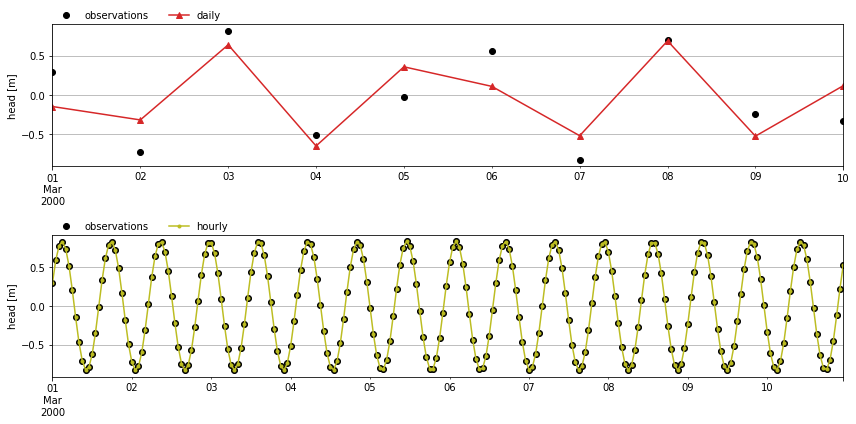

In [21]:
fig, (axd, axh) = plt.subplots(2, 1, figsize=(12, 6))

htsel.loc["2000-03-01":"2000-03-10"].plot(
    ax=axh, linestyle="none", marker="o", color="k", label="observations"
)

ml_D.observations().loc["2000-03-01":"2000-03-10"].plot(
    ax=axd, linestyle="none", marker="o", color="k", label="observations"
)
ml_D.simulate().loc["2000-03-01":"2000-03-10"].plot(
    ax=axd, marker="^", color="C3", label="daily"
)
ml_H.simulate().loc["2000-03-01":"2000-03-10"].plot(
    ax=axh, marker=".", c="C8", label="hourly"
)

for iax in (axd, axh):
    iax.legend(loc=(0, 1), frameon=False, ncol=4)
    iax.set_ylabel("head [m]")
    iax.grid(True)

fig.tight_layout()

### Pumping test

In this example we will generate a synthetic time series that is influenced by
both recharge and a pumping test.

First we start by downloading some hourly precipitation and evaporation data
from a weather station in the Netherlands. We calculate the hourly potential
Makkink evaporation from the temperature (T) and radiation (Q).

In [22]:
knmi = hpd.read_knmi(
    xy=[(30760, 385968)],  # some x,y location in m RD (epsg:28992)
    meteo_vars=("RH", "T", "Q"),
    starts="2019-01-01",
    ends="2022-12-31",
    settings={
        "normalize_index": False,
        "fill_missing_obs": False,
        "interval": "hourly",
        "inseason": False,
    },
)

Extract the relevant series from the dataset and calculate the potential evaporation.

In [23]:
# get hourly precipitation
prec = knmi.loc["RH_VLISSINGEN", "obs"]["RH"]

# calculate potential evaporation
t = knmi.loc["T_VLISSINGEN", "obs"]
q = knmi.loc["Q_VLISSINGEN", "obs"]
evap = hpd.io.io_knmi.makkink(t["T"], q["Q"])

The well for the pumping test discharge 100 m³/h between October 1, 2022 till
October 31, 2022. We define a time series for the discharge of the well.

In [24]:
qw = pd.Series(index=pd.date_range("2022-09-30", "2022-11-30", freq="10T"), data=0)
qw.loc["2022-10"] = 100 * 24.0

Next we define two response functions, one for the recharge, and the other for
the pumping well. These are used to generate a synthetic head time series.

In [25]:
# response for recharge
rf_rch = ps.Exponential()
A_rch = 5e3
a_rch = 10.0
f_rch = -1.1

# response for pumping well
rf_well = ps.Hantush(up=False)
A_well = -2e-4
a_well = 0.2
b_well = 0.1

We calculate the head contributions of each stress and add them together to
create a synthetic head time series. For the recharge we generate an hourly
head time series. For the pumping well we use a 10-minute timestep, which we
resample to an hourly time series to add the two together.

In [26]:
# calculate precipitation excess
pe = prec + f_rch * evap

# generate head contributions of each stress
h_rch = generate_synthetic_heads(pe, rf_rch, (A_rch, a_rch), dt=1 / 24.0)
h_well = generate_synthetic_heads(
    qw, rf_well, (A_well, a_well, b_well), dt=1 / (24.0 * 6)
)

# add time series to generate synthetic heads with freq="H"
head = h_rch + h_well.reindex(h_rch.index).fillna(0.0)

Plotting the resulting synthetic heads (with and without pumping).

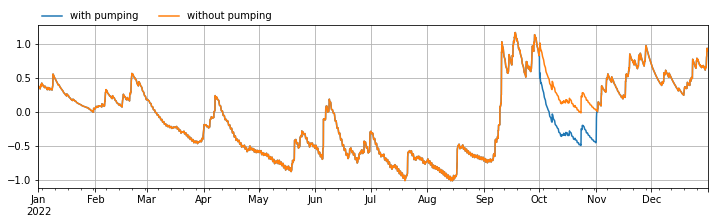

In [27]:
ax = head.loc["2022"].plot(label="with pumping", figsize=(12, 3))
h_rch.loc["2022"].plot(label="without pumping")
ax.grid(True)
ax.legend(loc=(0, 1), frameon=False, ncol=2);

The effect of resampling the drawdown of the well with hourly and daily
timesteps is shown below. The daily time series (black x's) has no data points
in the early stages of the pumping or recovery tests, and only contains
information about the steady state drawdown. The hourly time series (orange
dots) has a few data points in the period when the head is changing as a result
of the well turning on or off. This shows why modeling on an hourly timestep
might be preferable in this situation.

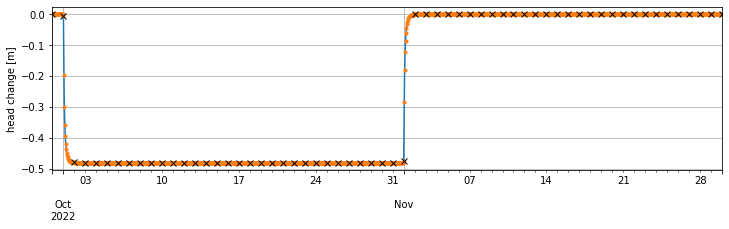

In [34]:
ax = h_well.plot(figsize=(12, 3))
h_well_h = ps.ts.pandas_equidistant_sample(h_well, "H")
h_well_d = ps.ts.pandas_equidistant_sample(h_well, "D")
h_well_h.plot(ax=ax, marker=".", ls="none")
h_well_d.plot(ax=ax, marker="x", ls="none", color="k")
ax.grid(True)
ax.set_ylabel("head change [m]");

We defined our pumping time series on a 10-minute interval, but for modeling
with freq="H" we want an hourly stress. We resample the original time series to
hourly using `ps.ts.timestep_weighted_resample`.

In [29]:
qw_h = ps.ts.timestep_weighted_resample(qw, index=h_rch.index).fillna(0.0)

Next we build two Pastas models, one with `freq="H"`and one with `freq="D"`. We
don't adjust the heads or any of the stresses for the daily model, and just let
Pastas take care of the resampling for us.

In [30]:
# hourly model
ml_h = ps.Model(head, name="H", freq="H")
rm = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="recharge")
wm = ps.StressModel(qw_h, rfunc=ps.Hantush(), name="well", settings="well", up=False)
ml_h.add_stressmodel([rm, wm])
ml_h.solve(noise=False, report=False, fit_constant=False)

# daily model
ml_d = ps.Model(head, name="D", freq="D")
rm = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="recharge")
wm = ps.StressModel(qw_h, rfunc=ps.Hantush(), name="well", settings="well", up=False)
ml_d.add_stressmodel([rm, wm])
ml_d.solve(noise=False, report=False, fit_constant=False)

Let's take a look at the R² for both models. Both models fit pretty much perfectly with the data.

In [36]:
c = ps.CompareModels([ml_d, ml_h])
c.get_metrics(metric_selection=["rsq"]).round(5)

,D,H
rsq,0.99992,0.99999


Comparing the observations and the two model results around the time of the
pumping test shows that both models perform well, though the daily model does
show a little less detail, for obvious reasons.

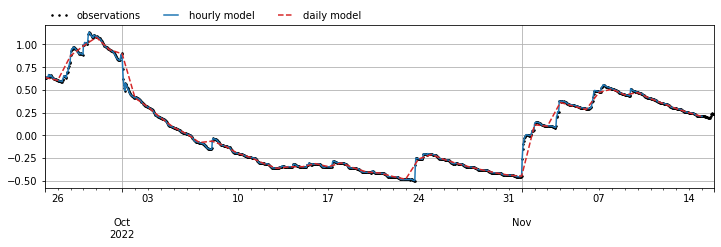

In [31]:
tmin = "2022-09-25"
tmax = "2022-11-15"

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

sim_h = ml_h.simulate(tmin=tmin, tmax=tmax)
sim_d = ml_d.simulate(tmin=tmin, tmax=tmax)

head.loc[tmin:tmax].plot(
    ax=ax, marker=".", color="k", ls="none", ms=3, label="observations"
)
sim_h.plot(ax=ax, label="hourly model")
sim_d.plot(ax=ax, label="daily model", color="C3", ls="dashed")

ax.grid(True)
ax.legend(loc=(0, 1), frameon=False, ncol=3, numpoints=3);

Comparing the estimated parameters with the true values we defined before, we
can see that the recharge estimates are very close to the actual values. For
the well the gain (`well_A`) is estimated well by both models. The parameters
`a` and `b` however, are only estimated well by the hourly model. This makes
sense because the daily model does not have sufficient observations in the
early periods after the start and end of pumping to estimate these parameters.
So the daily model is able to estimate the steady state drawdown caused by the
well, but not the parameters that determine the shape of the drawdown curve.

In [32]:
dfparams = c.get_parameters()
dfparams["True values"] = (A_rch, a_rch, f_rch, A_well, a_well, b_well, 0.0)
dfparams.round(4)

,D,H,True values
recharge_A,5004.1419,4993.4995,5000.0000
recharge_a,10.0051,9.9901,10.0000
recharge_f,-1.0993,-1.1028,-1.1000
well_A,-0.0002,-0.0002,-0.0002
well_a,0.0021,0.2053,0.2000
well_b,0.0000,0.0932,0.1000
constant_d,0.0004,0.0013,0.0000


The consequence of the daily model not being able to estimate the parameters
`a` and `b` is clearly visible if we use the estimated parameters by both
models to reconstruct drawdown curves on a 10-minute interval. The parameters
estimated by the hourly model clearly follow the true drawdown, whereas
parameters of the daily model get the steady-state drawdown right, but not the
drawdown in the early stages after the well starts pumping.

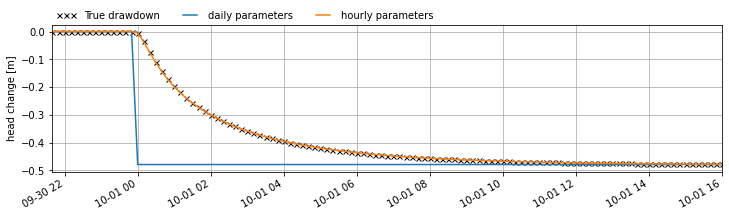

In [33]:
dd_d_10M = generate_synthetic_heads(
    qw, ps.Hantush(), ml_d.get_parameters("well"), dt=1 / (24 * 6.0)
)
dd_h_10M = generate_synthetic_heads(
    qw, ps.Hantush(), ml_h.get_parameters("well"), dt=1 / (24 * 6.0)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

h_well.plot(
    ax=ax, x_compat=True, label="True drawdown", marker="x", color="k", ls="none", ms=5
)
dd_d_10M.plot(ax=ax, label="daily parameters", x_compat=True)
dd_h_10M.plot(ax=ax, label="hourly parameters", x_compat=True)

ax.set_ylabel("head change [m]")
ax.set_xlim(qw.index[130], qw.index[240])
ax.grid(True)
ax.legend(loc=(0, 1), frameon=False, ncol=3, numpoints=3);